# Introduction

This notebook is used to experiment with different machine learning algorithms to train a price prediction model to be used by a trading systems that makes autonomous trading decisions.

The models aim to predict the future price of an asset after commissions.

# 1. Import necessary modules

In [2]:
import boto3
import joblib
import os
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from ta.trend import ADXIndicator
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.trend import MACD

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization

from keras.initializers import glorot_uniform
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import ParameterGrid
from keras.utils import to_categorical
from keras.regularizers import l2
import matplotlib.pyplot as plt
import talib
from sklearn.metrics import f1_score
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import butter, sosfilt
from concurrent.futures import ProcessPoolExecutor, as_completed
from datetime import datetime, timedelta

# 2. Define Helper Functions

In [50]:
def calculate_monthly_trade_volume(symbol):
    
    """Function to calculate the monthly trading volume for a symbol"""

    month_end = datetime.today()
    month_start = month_end - timedelta(days=30) #1 month ago 

    # Fetch historical data
    data = yf.download(symbol, start=month_start, end=month_end)

    # Resample the data to monthly frequency and sum the volumes
    monthly_trade_volume = data['Volume'].sum()

    return monthly_trade_volume

In [ ]:
def calculate_trading_fee(trade_value, monthly_trade_volume, asset_type, asset_price):

    """Function to Calculate IBKR commission fees per trade"""

    max_fee_rate = 1 #Initialize as 1 because Forex asset type does not have a max_fee_rate value
    num_units = trade_value / asset_price

    if asset_type == "Stock":
        commission_rate = 0.005  # USD 0.005 per share
        calculated_commission = commission_rate * num_units
        max_fee_rate = 0.01  # Maximum fee is 1% of trade value
        min_fee_per_order = 1.00  # Minimum fee per order is USD 1.00

    elif asset_type == "Crypto":
        if monthly_trade_volume <= 100000:
            commission_rate = 0.0018 # 0.18% of trade value

        elif 100000 < monthly_trade_volume <= 1000000:
            commission_rate = 0.0015 # 0.15% of trade value

        else:
            commission_rate = 0.0012 # 0.12% of trade value

        calculated_commission = commission_rate * trade_value 
        max_fee_rate = 0.01  # Maximum fee is 1% of trade value
        min_fee_per_order = 1.75  # Minimum fee per order is USD 1.75

    elif asset_type == "Forex":
        if monthly_trade_volume <= 1000000000:
            commission_rate = 0.0001 * 0.20  # 0.20 basis points x trade value (1 basis point = 0.0001)
            min_fee_per_order = 2.00  # Minimum fee per order is USD 2.00

        elif 1000000000 < monthly_trade_volume <= 2000000000:
            commission_rate = 0.0001 * 0.15  # 0.15 basis points x trade value (1 basis point = 0.0001)
            min_fee_per_order = 1.50  # Minimum fee per order is USD 1.50

        elif 2000000000 < monthly_trade_volume <= 5000000000:
            commission_rate = 0.0001 * 0.10  # 0.10 basis points x trade value (1 basis point = 0.0001)
            min_fee_per_order = 1.25  # Minimum fee per order is USD 1.25

        else:
            commission_rate = 0.0001 * 0.08 # 0.08 basis points x trade value (1 basis point = 0.0001)
            min_fee_per_order = 1.00  # Minimum fee per order is USD 1.00

        calculated_commission = commission_rate * trade_value 

    max_commission = max_fee_rate * trade_value

    # Calculate commission fee
    commission_fee = max(min_fee_per_order, min(calculated_commission, max_commission))

    return commission_fee

In [ ]:
def prediction_check(returns, returns_after_commission):

    """Function to check whether to make a trade.
        If the direction of return is consistent with the direction of the return after the trade, 
        make a trade in the direction of the return.
        Else, return 0 which means don't make a trade or don't change trade direction."""
    if np.sign(returns) == np.sign(returns_after_commission):
        return np.sign(returns)
    else:
        return 0

In [51]:
def get_data(symbol):
    ''' Imports the data from yahoo finance and calulates realized returns and future returns.
        Future returns is the feature to be predicted by the machine learning models'''
    
    raw = yf.download(symbol, period="56d", interval = '15m').dropna() 
    raw["realized_returns"] = np.log(raw['Close'] / raw['Close'].shift(1))
    raw["future_returns"] = raw["realized_returns"].shift(-1)
    return raw

In [52]:
get_data('AA').dropna()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,realized_returns,future_returns
Datetime,,,,,,,,
2023-10-05 09:45:00,26.840000,27.139999,26.770000,27.115601,27.115601,179269,0.010775,-0.003162
2023-10-05 10:00:00,27.105000,27.105000,26.820000,27.030001,27.030001,120411,-0.003162,-0.004821
2023-10-05 10:15:00,27.030001,27.030001,26.870001,26.900000,26.900000,70999,-0.004821,-0.002233
2023-10-05 10:30:00,26.900000,26.945000,26.780001,26.840000,26.840000,103692,-0.002233,0.000689
2023-10-05 10:45:00,26.818001,26.930000,26.809999,26.858500,26.858500,108142,0.000689,-0.003300
...,...,...,...,...,...,...,...,...
2023-12-22 11:00:00,33.419998,33.755001,33.293701,33.755001,33.755001,332411,0.012371,0.001332
2023-12-22 11:15:00,33.759998,33.860001,33.740002,33.799999,33.799999,224913,0.001332,0.001478
2023-12-22 11:30:00,33.794998,34.150002,33.790001,33.849998,33.849998,481929,0.001478,0.006185


# 3. Define Feature Engineering Functions

Note that some of the features used in my final model are ommited here

In [284]:
def price_change_lags(df, col_list, lags):
    
    """Calculate price lag features"""
    
    change_lag_cols = []

    for col in col_list:
        for lag in range(1, lags + 1):
            change_lag_cols.append(f'{col}_Change_Lag_{lag}')
            df[f'{col}_Change_Lag_{lag}'] = df[col].pct_change(periods=lag)

    return change_lag_cols

def calculate_ema(df, columns, periods= [10, 50, 100, 200]):
    
    """Calculate the Exponential Moving Average"""
    
    ema_cols = []

    for col in columns:
        for period in periods:
            ema_col = f'{col}_EMA_{period}'
            ema_cols.append(ema_col)
            df[ema_col] = df[col].ewm(span=period, adjust=False).mean()

    return ema_cols

def calculate_sma(df, columns, periods= [10, 50, 100, 200]):
    
    """Calculate the Simple Moving Average"""
    
    sma_cols = []

    for col in columns:
        for period in periods:
            sma_col = f'{col}_SMA_{period}'
            sma_cols.append(sma_col)
            df[sma_col] = df[col].rolling(window=period).mean()

    return sma_cols

def calculate_std(df, columns, periods = [10, 50, 100, 200]):
    
    """Calculate the Standard Deviation (An indicator of volatility)"""
    
    std_cols = []
    df.dropna(inplace = True)
    
    for col in columns:
        for period in periods:
            std_col = f'{col}_STD_{period}'
            std_cols.append(std_col)
            df[std_col] = df[col].rolling(window=period).std()
    return std_cols

def calculate_sma_ratios(df, columns, periods = [10, 50, 100, 200]):
    
    """Calculate the SMA Ratios"""
    
    sma_ratio_cols = []
    
    for col in columns:
        for period in periods:
            sma_col = f'{col}_SMA_{period}'
            ratio_col = f'{col}_Ratio_SMA_{period}'
            sma_ratio_cols.append(ratio_col)
            df[ratio_col] = df[col] / df[sma_col]

    return sma_ratio_cols


def compute_fourier_transform(series):
    
    """Calculate the Phase and Magnitude of the Fourier transform"""
    
    fft_result = np.fft.fft(series)
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    return magnitude, phase

def apply_fourier_transform(df, columns):
    
    fourier_transform_cols = []
    # Compute Fourier transform for all columns in 'feature_columns'
    for col in columns:
        magnitude, phase = compute_fourier_transform(df[col])
        fourier_transform_cols.append(f'{col}_Magnitude')
        fourier_transform_cols.append(f'{col}_Phase')
        df[f'{col}_Magnitude'] = magnitude
        df[f'{col}_Phase'] = phase
    return fourier_transform_cols

def prepare_features(data, lags):
    ''' Prepares the feature columns for the training set and test set.
    '''
    col_list = ['Open', 'High', 'Low', 'Close', 'Volume']
    data_copy = data.copy()

    # Calculate the returns
    data_copy['price_change'] = data_copy['Close'].pct_change()

    # Calculate the daily gains and losses
    data_copy['gain'] = np.where(data_copy['price_change'] > 0, data_copy['price_change'], 0)
    data_copy['loss'] = np.where(data_copy['price_change'] < 0, -data_copy['price_change'], 0)

    # Calculate the average gains and losses over the last 14 periods
    period = 14
    data_copy['avg_gain'] = data_copy['gain'].rolling(window=period).mean()
    data_copy['avg_loss'] = data_copy['loss'].rolling(window=period).mean()

    # Calculate the RS (Relative Strength)
    data_copy['RS'] = data_copy['avg_gain'] / data_copy['avg_loss']

    # Calculate the RSI
    data_copy['RSI'] = 100 - (100 / (1 + data_copy['RS']))

    # Calculate the Bollinger Bands
    bb = BollingerBands(data_copy['Close'])
    data_copy['upper_band'] = bb.bollinger_hband()
    data_copy['lower_band'] = bb.bollinger_lband()

    # Calculate the 12-day and 26-day Exponential Moving Averages (EMAs) for MACD
    macd = MACD(data_copy['Close'])
    data_copy['MACD'] = macd.macd()
    data_copy['Signal_Line'] = macd.macd_signal()

    # Calculate the Stochastic Oscillator
    period = 14
    data_copy['%K'] = 100 * (data_copy['Close'] - data_copy['Close'].rolling(window=period).min()) / (
            data_copy['Close'].rolling(window=period).max() - data_copy['Close'].rolling(window=period).min())
    data_copy['%D'] = data_copy['%K'].rolling(window=3).mean()

    # Calculate the ADX
    adx = ADXIndicator(data_copy['High'], data_copy['Low'], data_copy['Close'], window=14, fillna=True)
    data_copy['ADX'] = adx.adx()

    # Time-related features
    data_copy['day_of_week'] = data_copy.index.dayofweek
    data_copy['hour_of_day'] = data_copy.index.hour
    data_copy['minute_of_day'] = data_copy.index.minute
    

    derived_columns = [ 'RSI', 'upper_band', 'lower_band',
                        'MACD', 'Signal_Line', '%K', '%D', 'ADX', 
                        'day_of_week', 'hour_of_day', 'minute_of_day']
    
    derived_columns += price_change_lags(data_copy, col_list, lags)
    derived_columns += calculate_ema(data_copy, col_list)
    derived_columns += calculate_sma(data_copy, col_list)
    derived_columns += calculate_std(data_copy, col_list)
    derived_columns += calculate_sma_ratios(data_copy, col_list)
    derived_columns += apply_fourier_transform(data_copy, col_list)

    data_copy.dropna(inplace=True)
    return data_copy[derived_columns] #  + arima_feature_columns

# 4. Train and Test Different Models using data for a Single Instrument

In [285]:
data = get_data('AA')
monthly_trade_volume = calculate_monthly_trade_volume('AA')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [286]:
train_ratio = 0.7
split_index = int(len(data) * train_ratio)
split_date = data.index[split_index-1]
train_start = data.index[0]
test_end = data.index[-1]

In [287]:
#test data should start 200 periods before the actual test period because the test features needs 200 periods to calculate
#the featured
test_split_index = split_index - 200
test_split_date = data.index[test_split_index-1]

In [288]:
train_set = data[train_start : split_date]
test_set = data[test_split_date : test_end]

In [ ]:
# Split the data into training and testing sets
X_train = prepare_features(train_set, 10)
train_set['commission_rate'] = train_set.apply(lambda row: calculate_trading_fee(2000, monthly_trade_volume, 'Stock', row['Close']), axis = 1) / 2000 #ratio of commission is the commission fee / trade valu
train_set['future_returns_after_commission'] = train_set['future_returns'] - train_set['commission_rate'] #subtract the returns by the commission rate
train_set['trade_signal'] = train_set.apply(lambda row: prediction_check(row['future_returns'], row['future_returns_after_commission']), axis = 1) #only make a trade if future returns and future returns after commission are in same direction
y_train = train_set.iloc[-len(X_train):]['trade_signal']


X_test = prepare_features(test_set, 10)
test_set['commission_rate'] = test_set.apply(lambda row: calculate_trading_fee(2000, monthly_trade_volume, 'Stock', row['Close']), axis = 1) / 2000 #ratio of commission is the commission fee / trade valu
test_set['future_returns_after_commission'] = test_set['future_returns'] - test_set['commission_rate'] #subtract the returns by the commission rate
test_set['trade_signal'] = test_set.apply(lambda row: prediction_check(row['future_returns'], row['future_returns_after_commission']), axis = 1)
y_test = test_set.iloc[-len(X_test):]['trade_signal']

In [ ]:
# Standardize the features
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert categorical target variable to numerical using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Apply OneHotEncoder to the target variable
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))

# Reshape input data for LSTM (samples, time steps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

## Random Forest 

In [293]:
random_forest = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.4830508474576271

## Feature Importance

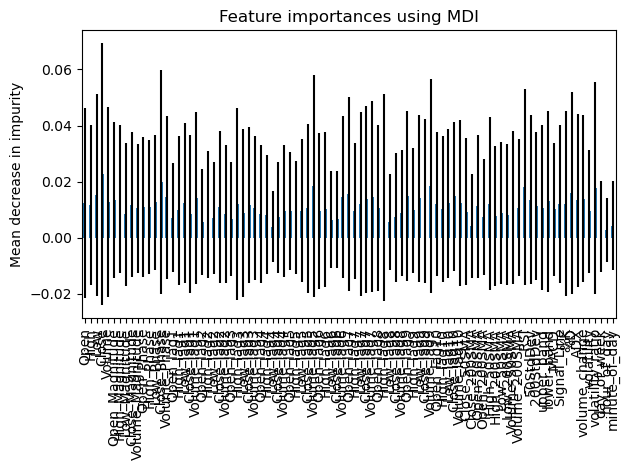

In [36]:
feature_names = X.columns
importances = random_forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [175]:
relative_importances = pd.DataFrame(index=feature_names, data=forest_importances, columns=["importance"])

# Sort the DataFrame to learn most important features
relative_importances.sort_values(by="importance", ascending=False)[:-60]

,importance
Close,0.022653
Close_Phase,0.019868
Volume_lag5,0.018575
Volume_lag9,0.018451
RSI,0.018022
volatility_ratio,0.017655
%D,0.015921
Open_lag7,0.015535
Low,0.015329
Open_lag9,0.014939


## DNN

In [162]:
# Build a deep neural network model

dropout_rate = 0.3
units_lstm = 75
units_dense = 32
model = Sequential()
model.add(LSTM(units_lstm, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
               return_sequences=True)) #, kernel_regularizer=l2(0.01)
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(LSTM(units_lstm, return_sequences=True)) #, kernel_regularizer=l2(0.01)
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(LSTM(units_lstm, return_sequences=True)) #, kernel_regularizer=l2(0.01)
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

#Added
model.add(LSTM(units_lstm, return_sequences=True)) #, kernel_regularizer=l2(0.01)
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(LSTM(units_lstm)) #, kernel_regularizer=l2(0.01)
model.add(Dropout(dropout_rate))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_lstm, y_train_onehot, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
evaluation = model.evaluate(X_test_lstm, y_test_onehot)
accuracy = evaluation[1]
print(f"Accuracy on the test set: {accuracy}")

Epoch 1/50
11/11 [==============================] - 14s 473ms/step - loss: 0.9446 - accuracy: 0.4759 - val_loss: 1.0293 - val_accuracy: 0.4286
Epoch 2/50
11/11 [==============================] - 3s 275ms/step - loss: 0.8921 - accuracy: 0.4806 - val_loss: 1.0100 - val_accuracy: 0.4286
Epoch 3/50
11/11 [==============================] - 3s 276ms/step - loss: 0.8816 - accuracy: 0.4821 - val_loss: 1.0052 - val_accuracy: 0.4286
Epoch 4/50
11/11 [==============================] - 3s 273ms/step - loss: 0.8785 - accuracy: 0.4806 - val_loss: 1.0027 - val_accuracy: 0.4286
Epoch 5/50
11/11 [==============================] - 3s 271ms/step - loss: 0.8777 - accuracy: 0.4806 - val_loss: 0.9730 - val_accuracy: 0.4720
Epoch 6/50
11/11 [==============================] - 3s 271ms/step - loss: 0.8648 - accuracy: 0.4759 - val_loss: 0.9617 - val_accuracy: 0.4658
Epoch 7/50
11/11 [==============================] - 3s 271ms/step - loss: 0.8820 - accuracy: 0.4914 - val_loss: 0.9593 - val_accuracy: 0.4658
Epoch

## XGB

In [254]:
xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,  # Learning rate (adjust as needed)
    n_estimators=100,  # Number of boosting rounds (adjust as needed)
    max_depth=3,  # Maximum tree depth (adjust as needed)
    subsample=0.8,  # Fraction of samples used for training each tree
    colsample_bytree=0.8,  # Fraction of features used for training each tree
    random_state=42  # Random seed for reproducibility
)

# Fit the classifier to the training data
xgb_classifier.fit(X_train, y_train_onehot)
y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_pred, y_test_onehot)
accuracy

0.3771186440677966

## Decision Tree

In [255]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)
y_pred = decision_tree_classifier.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.4194915254237288

## Basic Out-of-Box MLP

In [ ]:
mlp = MLPClassifier()
mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)
accuracy = accuracy_score(y_pred, y_test)
accuracy

# SVM

In [257]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.4830508474576271

## 5. Train and Test Different Models on all Instruments

In this section, I experiment with various models and train them on all available assets to determine how well they predict future prices across different assets

## Define Train-Test Split Data Function

In [ ]:
def train_test_split_data(symbol):
    
    """Function to get data for the symbol and split into train and test sets"""
    monthly_trade_volume = calculate_monthly_trade_volume(symbol)
    data = get_data(symbol)

    train_ratio = 0.7
    split_index = int(len(data) * train_ratio)
    split_date = data.index[split_index-1]
    train_start = data.index[0]
    test_end = data.index[-1]

    #test data should start 200 periods before the actual test period because the test features needs 200 periods to calculate
    test_split_index = split_index - 200
    test_split_date = data.index[test_split_index-1]

    train_set = data[train_start : split_date]
    test_set = data[test_split_date : test_end]

    # Split the data into training and testing sets
    X_train = prepare_features(train_set, 10)
    train_set['commission_rate'] = train_set.apply(lambda row: calculate_trading_fee(2000, monthly_trade_volume, 'Stock', row['Close']), axis = 1) / 2000 #ratio of commission is the commission fee / trade value. Assume trade value is $2000
    train_set['future_returns_after_commission'] = train_set['future_returns'] - train_set['commission_rate'] #subtract the returns by the commission rate
    train_set['trade_signal'] = train_set.apply(lambda row: prediction_check(row['future_returns'], row['future_returns_after_commission']), axis = 1)
    y_train = train_set.iloc[-len(X_train):]['trade_signal']


    X_test = prepare_features(test_set, 10)
    test_set['commission_rate'] = test_set.apply(lambda row: calculate_trading_fee(2000, monthly_trade_volume, 'Stock', row['Close']), axis = 1) / 2000 #ratio of commission is the commission fee / trade value. Assume trade value is $2000
    test_set['future_returns_after_commission'] = test_set['future_returns'] - test_set['commission_rate'] #subtract the returns by the commission rate
    test_set['trade_signal'] = test_set.apply(lambda row: prediction_check(row['future_returns'], row['future_returns_after_commission']), axis = 1)
    y_test = test_set.iloc[-len(X_test):]['trade_signal']
    
    return X_train, y_train, y_train, y_test

## Deep Neural Network

In [17]:
def create_model(units_lstm, dropout_rate, units_dense, X_train_lstm):
    
    """Function to create a deep neural network model"""
    model = Sequential()

    # Use Glorot uniform initializer for LSTM layers
    lstm_initializer = glorot_uniform(seed=42)

    # Add L2 regularization to LSTM layers
    model.add(LSTM(units_lstm, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
                   return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(LSTM(units_lstm, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(LSTM(units_lstm, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    #Added
    model.add(LSTM(units_lstm, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(LSTM(units_lstm, kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [272]:
def test_model_dnn(symbol):
    
    """Train and test a deep neural network to predict future prices for all available instruments. """
    
    #define train and test features
    X_train, y_train, y_train, y_test = train_test_split_data(symbol)

    # Standardize the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert categorical target variable to numerical using LabelEncoder
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Apply OneHotEncoder to the target variable
    onehot_encoder = OneHotEncoder(sparse=False)
    y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
    y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))

    # Reshape input data for LSTM (samples, time steps, features)
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    model = create_model(75, 0.3, 32, X_train_lstm)

    # Train the model
    model.fit(X_train_lstm, y_train_onehot, epochs=50, batch_size=64, validation_split=0.2, verbose=0)

    # Evaluate the model on the test set
    evaluation = model.evaluate(X_test_lstm, y_test_onehot, verbose=0)
    accuracy = evaluation[1]

    # Make predictions on the test set
    y_pred_onehot = model.predict(X_test_lstm)
    y_pred_encoded = np.argmax(y_pred_onehot, axis=1)

    # Convert true labels to numerical using LabelEncoder
    y_test_encoded = label_encoder.transform(y_test)

    # Calculate F1-score
    f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted')

    return accuracy, f1

In [15]:
test_symbols = pd.DataFrame(backtest_results[backtest_results['Asset Type'] == 'Stock']['Symbol'])

In [298]:
test_symbols = backtest_results.copy()

In [58]:
def test_strategy_batch(symbol):
    """Function to run test_strategy in batches so as to conserve memory"""
    
    result = symbol.apply(test_model_dnn)
    return results

def process_batch(executor, batch):
    """Function to run the bacth function using different processor threads. This is to conserve memory by deleting unnecessary variables after 
        running each batch."""
    futures = [executor.submit(test_strategy_batch, symbol) for symbol in batch]
    results = []
    for future in as_completed(futures):
        results.extend(future.result())
    return results

In [ ]:
# Split symbols into batches
batch_size = 1  
symbol_batches = [test_symbols['Symbol'][i:i + batch_size] for i in range(0, len(test_symbols['Symbol']), batch_size)]

processed_results = []

for symbol_batch in symbol_batches:
    processed_results.append(test_strategy_batch(symbol_batch))
    
result_df = pd.concat(processed_results)
test_symbols = pd.merge(test_symbols, result_df, on='Symbol', how='left')

In [171]:
test_symbols['DNN Results Accuracy'].describe()

count    21.000000
mean      0.493560
std       0.101256
min       0.250000
25%       0.444444
50%       0.500000
75%       0.560976
max       0.653846
Name: DNN Results, dtype: float64

## Random Forest

In [294]:
def test_model_rf(symbol):
    
    #define train and test features
    X_train, y_train, y_train, y_test = train_test_split_data(symbol)

    # Train and evaluate the model
    random_forest = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)

    return accuracy

In [ ]:
test_symbols['RF Results'] = test_symbols['Symbol'].apply(test_model_rf)
test_symbols = test_symbols.dropna()

In [300]:
test_symbols['RF Results'].describe()

count    47.000000
mean      0.484318
std       0.037837
min       0.391489
25%       0.461864
50%       0.483696
75%       0.501064
max       0.610169
Name: RF Results, dtype: float64

## Basic MLP

In [301]:
def test_model_mlp(symbol):
    
    #define train and test features
    X_train, y_train, y_train, y_test = train_test_split_data(symbol)

    # Standardize the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert categorical target variable to numerical using LabelEncoder
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Apply OneHotEncoder to the target variable
    onehot_encoder = OneHotEncoder(sparse=False)
    y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
    y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))

    # Train and evaluate the model
    mlp = MLPClassifier()
    mlp.fit(X_train_scaled, y_train_onehot)
    y_pred = mlp.predict(X_test_scaled)
    accuracy = accuracy_score(y_pred, y_test_onehot)

    return accuracy

In [ ]:
test_symbols = test_symbols.dropna()
test_symbols['MLP Results'] = test_symbols['Symbol'].apply(test_model_mlp)

In [303]:
test_symbols['MLP Results'].describe()

count    47.000000
mean      0.366141
std       0.137544
min       0.004237
25%       0.302966
50%       0.421875
75%       0.454354
max       0.563559
Name: MLP Results, dtype: float64

## Decision Tree Model

In [304]:
def test_model_dt(symbol):
    
    #define train and test features
    X_train, y_train, y_train, y_test = train_test_split_data(symbol)

    # Train and evaluate the model
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(X_train, y_train)
    y_pred = decision_tree_classifier.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)

    return accuracy

In [ ]:
test_symbols['DT Results'] = test_symbols['Symbol'].apply(test_model_dt)

In [306]:
test_symbols['DT Results'].describe()

count    47.000000
mean      0.422624
std       0.059438
min       0.190678
25%       0.402542
50%       0.431624
75%       0.461864
max       0.514894
Name: DT Results, dtype: float64

## XGB Model

In [307]:
def test_model_xgb(symbol):
    
    #define train and test features
    X_train, y_train, y_train, y_test = train_test_split_data(symbol)
    
    # Convert categorical target variable to numerical using LabelEncoder
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Apply OneHotEncoder to the target variable
    onehot_encoder = OneHotEncoder(sparse=False)
    y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
    y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))

    # Train and evaluate the model
    xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,  # Learning rate (adjust as needed)
    n_estimators=100,  # Number of boosting rounds (adjust as needed)
    max_depth=3,  # Maximum tree depth (adjust as needed)
    subsample=0.8,  # Fraction of samples used for training each tree
    colsample_bytree=0.8,  # Fraction of features used for training each tree
    random_state=42  # Random seed for reproducibility
    )

    # Fit the classifier to the training data
    xgb_classifier.fit(X_train, y_train_onehot)
    y_pred = xgb_classifier.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test_onehot)

    return accuracy

In [ ]:
test_symbols['XGB Results'] = test_symbols['Symbol'].apply(test_model_xgb)

In [309]:
test_symbols['XGB Results'].describe()

count    47.000000
mean      0.351295
std       0.061033
min       0.097458
25%       0.323404
50%       0.368644
75%       0.389831
max       0.444915
Name: XGB Results, dtype: float64

# SVM

In [310]:
def test_model_svc(symbol):
    
    #define train and test features
    X_train, y_train, y_train, y_test = train_test_split_data(symbol)

    # Train and evaluate the model
    svc = SVC()

    # Fit the classifier to the training data
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)

    return accuracy

In [ ]:
test_symbols['SVC Results'] = test_symbols['Symbol'].apply(test_model_svc)

In [312]:
test_symbols['SVC Results'].describe()

count    47.000000
mean      0.476966
std       0.053958
min       0.373626
25%       0.439560
50%       0.472527
75%       0.516484
max       0.648352
Name: SVC Results, dtype: float64

# SVC-RF Ensemble

In [313]:
from sklearn.ensemble import VotingClassifier

In [314]:
def test_model_svc_rf_ensemble(symbol):
    
    """An ensemble of a Support Vector Machine and a Random Forest Model"""
    
    #define train and test features
    X_train, y_train, y_train, y_test = train_test_split_data(symbol)

    # Train and evaluate the model
    svc = SVC(probability = True)
    random_forest = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)

    # Create a VotingClassifier with soft voting
    voting_classifier = VotingClassifier(
        estimators=[('svc', svc), ('random_forest', random_forest)],
        voting='soft'
    )

    # Fit the ensemble model on the training data
    voting_classifier.fit(X_train, y_train)

    # Predictions on the validation set
    y_pred = voting_classifier.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)

    return accuracy

In [ ]:
test_symbols['SVC-RF Ensemble Results'] = test_symbols['Symbol'].apply(test_model_svc_rf_ensemble)

In [316]:
test_symbols['SVC-RF Ensemble Results'].describe()

count    47.000000
mean      0.487290
std       0.038154
min       0.394068
25%       0.466102
50%       0.483051
75%       0.506664
max       0.601695
Name: SVC-RF Ensemble Results, dtype: float64

## Compare Models Performances

In [317]:
test_symbols.describe()

,RF Results,MLP Results,DT Results,XGB Results,SVC Results,SVC-RF Ensemble Results
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.484318,0.366141,0.422624,0.351295,0.476966,0.487290
std,0.037837,0.137544,0.059438,0.061033,0.053958,0.038154
min,0.391489,0.004237,0.190678,0.097458,0.373626,0.394068
25%,0.461864,0.302966,0.402542,0.323404,0.439560,0.466102
50%,0.483696,0.421875,0.431624,0.368644,0.472527,0.483051
75%,0.501064,0.454354,0.461864,0.389831,0.516484,0.506664
max,0.610169,0.563559,0.514894,0.444915,0.648352,0.601695


# Test LSTM Model Strategy

In this model, I test the performance of the LSTM model across all symbols.

I am testing for metrics such as:

- Daily Mean Return
- Outperformance (How much the prediction Strategy outperforms a simp;e buy and hold strategy.
- Risk 
- Sharpe Ratio
- Max Drawdown
- Max Single Day Drawdown
- Hit Rate (Model Accuracy)
- Number of Trades
- Winning Day Percentage

In [ ]:
from MLBacktesterLSTM import MLBacktesterLSTM #import a Backtester Model Defined elsewhere

In [15]:
end = datetime.strptime('2023-12-30', '%Y-%m-%d') 
start = end - timedelta(days=56) #approx 2 months ago. 
trade_value = 2000

def test_strategy(instrument):
    try:
        tester = MLBacktesterLSTM(instrument, start, end, 'Stock', trade_value, '15m')
        if tester.qualify_symbol():
            results = tester.test_strategy()
        else:
            results = ['Not Qualified'] * 9
        print(results)
        return results
    
    except Exception as e:
        print(str(instrument) + ' : ' + str(e))
        return [0] * 9

In [ ]:
results = backtest_results['Symbol'].apply(test_strategy)

In [20]:
test_cols = ['daily_mean_return', 'outperf', 'risk', 'sharpe', 'max_drawdown', 'max_day_drawdown', 'hit_rate', 'num_trades', 'winning_days_percentage']

In [28]:
results_df = pd.DataFrame(results.tolist(), columns = test_cols)

In [29]:
results_df.describe()

,daily_mean_return,outperf,risk,sharpe,max_drawdown,max_day_drawdown,hit_rate,num_trades,winning_days_percentage
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.000132,0.004308,0.001739,-inf,-0.008412,-0.007221,48.000000,0.100000,41.000000
std,0.004931,0.009860,0.001355,NaN,0.005616,0.005299,7.221786,0.303046,37.375644
min,-0.009938,-0.010231,0.000000,-inf,-0.027135,-0.027135,33.333333,0.000000,0.000000
25%,-0.002783,-0.000354,0.001077,-1.727800,-0.011352,-0.009015,40.833333,0.000000,0.000000
50%,0.000000,0.001566,0.001551,-0.247643,-0.008105,-0.006439,46.666667,0.000000,50.000000
75%,0.001996,0.007721,0.002077,0.400035,-0.004293,-0.004152,53.333333,0.000000,50.000000
max,0.021214,0.045699,0.008404,5.231089,0.000000,0.000000,63.333333,1.000000,100.000000
